# Do there exist significant differences between the balances of my various customers' cohorts?

## Goals

One of the key problems in data science is that of determining if a pattern you notice is significant enough to warrant further action. In this case, you will learn a fundamental tool to approach this problem called **statistical hypothesis testing**. By the end of this case, you should know how to conduct a hypothesis test, analyze its outcome, and identify its shortcomings.

## Introduction

**Business Context.** You are leading a business analytics unit in a bank and have been asked to support the marketing unit to conduct a customer segmentation analysis. You are provided with a dataset comprising a sample of customers, their bank account balances, and some demographic information about them. Different populations across the country have different income levels and may have different spending profiles. Your marketing team wants to know if there are significant differences in the bank balances of different subsegments of your customer base, so that they can design targeted products for different groups. 

**Business problem.** The marketing department wants you to determine: **"Do there exist statistically significant differences in the bank balances of your customer segments (by age, job, education, marital status, etc.)?"** 

**Analytical Context.** The dataset that we will use in this case was retrieved from Kaggle (https://www.kaggle.com/skverma875/bank-marketing-dataset). In this case, we will take the first step towards transitioning from **exploratory data analysis** to **confirmatory analysis**. We will: (1) learn a formal framework for hypothesis testing; (2) learn about $p$ - values; (3) generate a hypothesis from exploratory data analysis; and finally (4) analyze the results of a hypothesis test.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests

## Data Exploration

The data includes the account balance of 45,211 customers, along with several other characteristics:

In [5]:
bank = pd.read_csv("bank-full.csv")
bank.shape

(45211, 17)

In [6]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


The relevant features we will use in this case are:

1. **balance:** bank balance; key variable of interest
2. **job:** the title of the job (“management”, “technician”, etc)
3. **marital:** marital status ("single", "married" or "divorced")
4. **education:** different levels of education ("primary","secondary","tertiary","unknown")
5. **default:** the customer defaulted ("yes" or "no")
6. **loan:** the customer took out a loan ("yes" or "no")

In [7]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


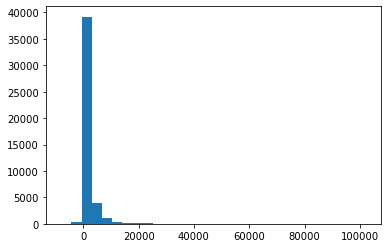

In [8]:
plt.hist(bank['balance'],bins = 30);

### Exercise 1:

From the tables and histogram above, we see a huge range in the bank balance of your customers. Why do you think this is?

**Answer.**

----------

Let us understand our data further by plotting the variables. Consider the variables `job`, `marital`, `education`, `default`, `housing`, `loan`. For each of these variables, we plot the number of customers in each category as follows.

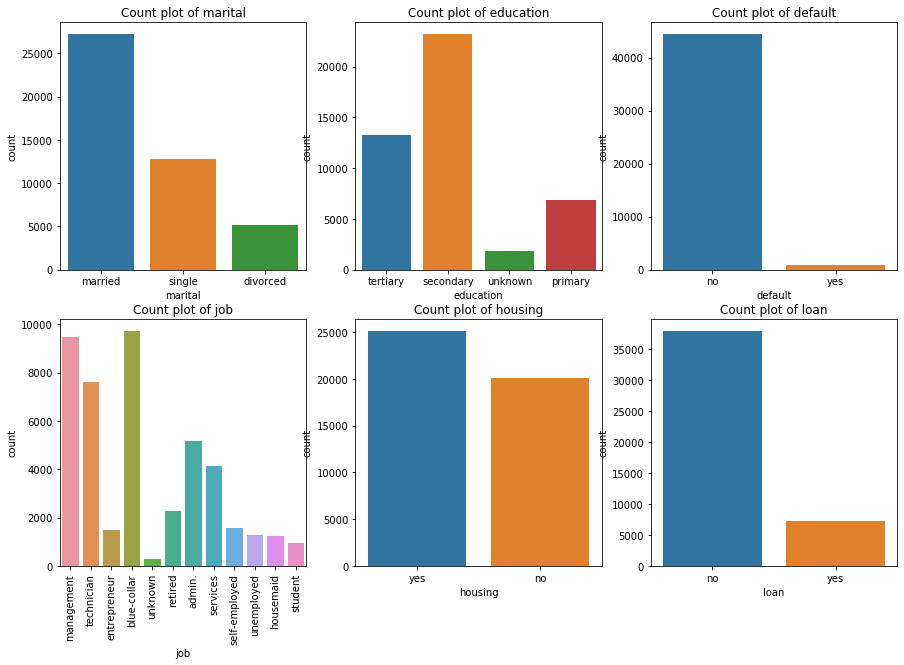

In [9]:
plt.figure(figsize=(15,10))
vars_to_look = ['marital','education','default','job','housing','loan']
for i, var in enumerate(vars_to_look):
    plt.subplot(2,3,i+1)
    if i ==3:
        plt.xticks(rotation = 90)
    sns.countplot(bank[var])
    plt.title("Count plot of " + var)    

### Exercise 2:

What can you conclude from the plots? 

**Answer.**

----------

### Exercise 3:

Last year the average balance for the entire population of the bank's customers was \\$1341.12. How much higher is the sample average balance this year? Is this difference significant?

**Answer.**

----------

## Analytical framework for hypothesis testing

The procedure that we use to help us decide whether a difference between the mean $\mu$ of a population and a reference value $\mu_0$ is **statistically significant** is called **hypothesis testing**. In our context,
$\mu$ is the average bank balance of the customers this year and $\mu_0$ is their average bank balance last year.

The first step is defining the null hypothesis (often indicated as $H_0$). For us, the null hypothesis will **always** correspond to the hypothesis of no change; that is, the status quo is still valid. Formally, this is written as: $ H_0: \mu = \mu_0 $.

In our case, $H_0$ would be equivalent in hypothesizing that the average balance for the entire customer population $\mu$ is the same as the average balance last year $\mu_0 = \$1341.12$. We wish to test if $H_0$ is wrong; that is, if $\mu$ is different from $\mu_0 = \$1341.12$.

Before diving further into the case, think about the following question:

### Question:

Suppose you are Ronald Fisher in the 1920s and you were to discover hypothesis testing for the first time ever. How would you go about testing the veracity of the null hypothesis $H_0$?  

**Answer:** One possible answer is the following. 

We can use a similar approach to that of the judicial system across the world: *[One is considered innocent until proven guilty](https://en.wikipedia.org/wiki/Presumption_of_innocence)* . We will accept the null hypothesis unless we find enough evidence against it.  Notice that this approach, as is the case the judiciary system, is not perfect. Even if we do not find evidence that goes against the null hypothesis, the null hypothesis may turn out to be wrong. 

### Alternative Hypothesis

In opposition to the null hypothesis, we define an alternative hypothesis (often indicated with $H_1$ or $H_a$) to challenge the status quo. We can have three different ways to define an alternative hypothesis:

1. $H_a: \mu \neq \mu_0$ (two-sided test)

2. $H_a: \mu > \mu_0$ (one-sided test)

3. $H_a: \mu < \mu_0$ (one-sided test)

The statistical test will help us decide if there is enough evidence to reject the null hypothesis in favor of an alternative.

### Conducting a hypothesis test

Returning to our case, suppose we wish to perform a statistical test to assess the hypothesis of management:

$$ H_0: \mu= 1341.12$$
$$ H_a: \mu \neq 1341.12$$

There are two possible outcomes for this test: (1) We conclude $H_0$ is false, and say we **reject $H_0$**. In this case we will conclude that there is statistical evidence for the alternative $H_a$ and that the bank balance of customers this year is indeed different from 1341.12 USD. Or (2) we **fail to reject $H_0$**. In this case, we conclude that there is not enough statistical evidence to say for sure that $H_0$ is false. **Notice that in the second case we cannot say that the original hypothesis is true.** (In fact, there is no test out there that will tell you that a hypothesis is true. Why do you think that is?)

We can use [Student's](https://www.guinness-storehouse.com/content/pdf/archive-factsheets/general-history/wsgosset-and-students-t-test.pdf) $t$-[test](https://en.wikipedia.org/wiki/Student's_t-test) to conduct a hypothesis testing for the mean of single population. The following command lets us run this test:

In [10]:
stats.ttest_1samp(bank['balance'], popmean=1341.122)

Ttest_1sampResult(statistic=1.4769973489267905, pvalue=0.13968331332845219)

### Reading the output of a statistical test: $p$ - values

Statistical tests report a **$p$ - value**. This is the key quantity that we will use to determine if the outcome of the test was significant. In short, if this value is larger than a certain threshold $\alpha$, called the significance level, we would reject the null hypothesis; we will go into more details later. For now, set $\alpha=0.05$. We can have two outcomes:

1. If this probability is smaller than our significance level ($p < \alpha$) we reject $H_0$ and we claim that the observed difference is "statistically significant".
2. If this probability is greater than our significance level ($p > \alpha$) we have to retain $H_0$ and we claim that the observed difference is not statistically significant.

### Question:

What do you conclude from the output? Do we reject $H_0$ or retain it?

**Answer.** Since the $p$ - value (0.13968) is larger than $\alpha=0.05$ we have to retain the null hypothesis.

**Note:** If the alternative is one-sided, say $H_a: \mu > \mu_0$  or $H_a: \mu < \mu_0$ . Then, just run the two-sided test and then divide the $p$ - value by half.

In [11]:
T,p = stats.ttest_1samp(bank['balance'], popmean=1341.122)
p_value = p/2

### Exercise 4:

We retained $H_0$ above. Are we 100% sure this decision is correct? Why or why not?

**Answer:**

----------

## Errors due to a wrong conclusion from a hypothesis test


There are two ways that a test can lead us to an incorrect decision:

1. When $H_0$ is true and we reject it. This is called **Type 1 Error**. It corresponds to obtaining a **false positive**.
2. When $H_0$ is false and we do not reject it. This is called **Type 2 Error**. It corresponds to having a **false negative**.

<table>
<tr>
<td></td><td><b>$H_0$ is true </b></td><td><b> $H_0$ is False</b></td>
</tr>
<tr>
<td><b>Reject $H_0$</b></td><td>Type I error</td><td>Correct Decision (True Positive)</td>
</tr>
<tr>
<td><b>Fail to Reject $H_0$ </b></td><td>Correct Decision (True negative) </td><td>Type II error</td>
</tr>
</table>

In general, we cannot control both the Type I and Type II error. So the type of an error we control depends on the situation.

### Exercise 5:

Discuss the following two scenarios with your teammates:

1. A patient is getting a diagnostic test for finding out if they are infected with HIV virus. What is the null hypothesis here? What is more serious here: making a Type I error (false positive) or Type II error (false negative)? Why?
2. You are getting a lot of spam emails, so you are writing a spam filter algorithm to detect whether an email is spam or not.  What is the null hypothesis here? What is more serious here: making a Type I error (false positive) or Type II error (false negative)? Why?

**Answer.**

----------

## Controlling the Type I error: significance level

It is standard practice to minimize the probability of making a Type I error. The probability, usually denoted by $\alpha$, is the significance level we introduced above. Typically we choose our significance level $\alpha$ to be $5\%$. Thus, if we reject $H_0$ with $\alpha = 0.05$, then there is only a $5\%$ chance that the conclusion we make is a false positive. Lowering the $\alpha$ value (say to $1\%$) will decrease the probability of making a false positive conclusion.

Of course, as we discussed before, because we control $\alpha$, we cannot control the Type II error we make. 

### Finding cohorts within your customer base

The goal of your team is to determine whether there are differences among different groups of customers in terms of bank balances. We start by looking at balances for two cohorts: those who took out a loan and those who didn't:

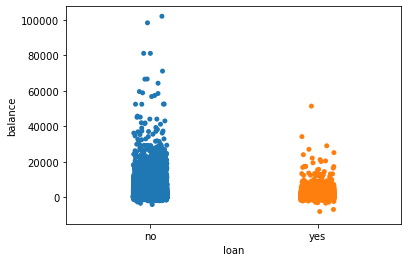

In [12]:
ax = sns.stripplot(x="loan", y="balance", data=bank)
plt.ylabel('balance')
plt.show()

Since the distribution of the data has heavy tails, it is hard to tell much from the strip plot whether there is a difference between the two subgroup means. We continue our data analysis by looking at summary statistics for each of the two groups:

In [13]:
bank[bank.loan=="yes"].balance.describe()

count     7244.000000
mean       774.309912
std       1908.283253
min      -8019.000000
25%          2.000000
50%        258.000000
75%        864.250000
max      51439.000000
Name: balance, dtype: float64

In [14]:
bank[bank.loan=="no"].balance.describe()

count     37967.000000
mean       1474.453631
std        3204.088951
min       -4057.000000
25%          94.000000
50%         496.000000
75%        1558.000000
max      102127.000000
Name: balance, dtype: float64

### Are the means of the loan and no loan groups significantly different?

We would like to test statistically whether the two group means are different from each other; that is, whether the difference between the mean balance in the groups with a loan ($\mu_1$) is different than the mean balance in the group with no loan ($\mu_2$). The testing procedure that we described can be used also to answer this question:
$$ H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

We get the following output:

In [15]:
loans=bank[bank.loan=="yes"].balance
no_loans=bank[bank.loan=="no"].balance

statistic, pvalue = stats.ttest_ind(loans,no_loans, equal_var=False)
statistic, pvalue

(-25.18086057755715, 2.7640564777544156e-137)

### Question:

What would you conclude from the above test?

**Answer:** The $p$ - value is very small (p = 2.76 e-1376); hence, we reject the null hypothesis that the two groups have the same mean.

### Differences by education

In our search to determine what factors are important in customer segmentation, we can identify in this large dataset if education plays a role in customer behavior. The variable `education` has 4 categories:

In [16]:
bank["education"].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

### Exercise 6:

Below we have written code to plot the balance by education via a strip plot (i.e. grouped 1D scatterplot). From your visual exploration, do you think there is a difference across the groups? 

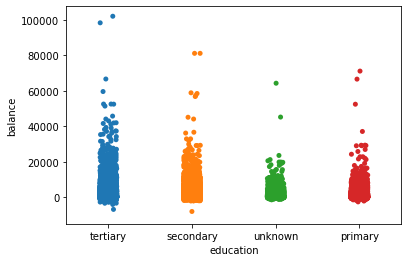

In [17]:
ax = sns.stripplot(x="education", y="balance", data=bank)
plt.ylabel('balance')
plt.show()

**Answer.**

----------

## Do bank balances differ significantly across education cohorts?

Our new hypothesis will be:

$$ H_0: \mu_1=\mu_2=\mu_3=\mu_4$$
$$H_a : \mathrm{At \,least\, one\, of\, the\, means\,} \mu_j \mathrm{\,is \,different\, from\, the \,others}.$$

To test this hypothesis we need an extension of the capabilities of the $t$ - test (which can test only two groups at the same time). This test is called **Analysis of Variance (ANOVA)**.

In [18]:
mod = ols('balance ~ education', data=bank).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
education,3.220417e+09,3.0,116.682074,2.849538e-75
Residual,4.159034e+11,45207.0,NaN,NaN


As we can see, looking at the $p$ - value that accompanies the $F$ - statistics, we obtain a strong rejection of the null hypothesis, leading us to conclude that education groups have some differences in their means. The ANOVA test does not tell us which pair of groups have means that are different from each other. To investigate these differences further, we are going first to report the descriptive statistics by group, and then display the group means in a bar chart:

In [19]:
bank[bank.education=="primary"].balance.describe()

count     6851.000000
mean      1250.949934
std       2690.743991
min      -2604.000000
25%         61.000000
50%        403.000000
75%       1390.000000
max      71188.000000
Name: balance, dtype: float64

In [20]:
bank[bank.education=="secondary"].balance.describe()

count    23202.000000
mean      1154.880786
std       2558.256739
min      -8019.000000
25%         55.000000
50%        392.000000
75%       1234.000000
max      81204.000000
Name: balance, dtype: float64

In [21]:
bank[bank.education=="tertiary"].balance.describe()

count     13301.000000
mean       1758.416435
std        3839.088305
min       -6847.000000
25%         104.000000
50%         577.000000
75%        1804.000000
max      102127.000000
Name: balance, dtype: float64

In [22]:
bank[bank.education=="unknown"].balance.describe()

count     1857.000000
mean      1526.754443
std       3152.228273
min      -1445.000000
25%        106.000000
50%        568.000000
75%       1699.000000
max      64343.000000
Name: balance, dtype: float64

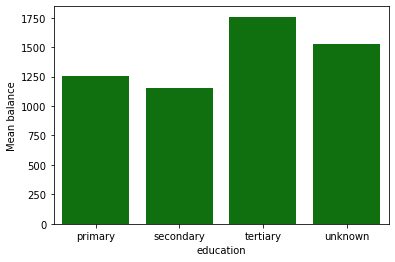

In [23]:
mean_balance_education=bank.groupby(by="education").balance.mean()
sns.barplot(x=mean_balance_education.index, y=mean_balance_education.values, color="green")
plt.ylabel("Mean balance")
plt.show()

Qualitatively there seems to be a big difference between tertiary and lower education levels, but the difference between primary and secondary education groups is more difficult to assess. We want to test if there is a significant difference in each pairwise comparison. To test this sequence of hypotheses we can use a variant of the $t$ - test, called a **pairwise $t$ - test**.


In [24]:
gb = bank.groupby(['education'])
group_names = bank["education"].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
  for j in range(i+1, len(group_names)):
    group1 = gb[["balance"]].get_group(group_names[i])
    group2 = gb[["balance"]].get_group(group_names[j])
    stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
    print(group_names[i] + " vs. " + group_names[j] + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
tertiary vs. secondary	16.18717929985782	1.4525474790099814e-58
tertiary vs. unknown	2.8825321831203117	0.003976238237673688
tertiary vs. primary	10.906634331433306	1.3023845080432282e-27
secondary vs. unknown	-4.95482328681934	7.83111710943088e-07
secondary vs. primary	-2.6255174227477864	0.0086639693661419
unknown vs. primary	3.445496944400963	0.0005789323657180873


The summary output above signals that there is a significant difference between each pairwise comparison.


### Exercise 7:

There are six comparisons in total that have to be conducted because the variable education has 4 levels. Discuss with a partner if, in your opinion, performing multiple tests simultaneously can increase the risk of erroneous inferences.
What will increase: Type I error or Type II error?

**Answer.**

----------

### Multiple comparisons: the Bonferroni correction

There are many ways to correct this issue, known as the "multiple comparisons" problem. One of the most classical methods is the Bonferroni correction. This method divides the significance level $\alpha$ by the number of multiple comparisons being performed (6 in this case). So if our $\alpha=0.05$ we will reject the null hypothesis only if the $p$ - value is less than 0.00833.

Notice that the $p$ - value for the comparison between "primary" and "secondary" education is 0.02126, and therefore higher than the adjusted confidence level. After the correction we cannot reject the null hypothesis that this pair has significantly different means. Several software packages directly adjust the $p$ - values for the increased probability of observing a false positive. If we perform this method for `education`, we get the following output:

In [26]:
pairwise_results = pairwise_ttests(dv='balance', between = ['education'], padjust='bonf', data=bank)
pairwise_results

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,education,tertiary,secondary,False,True,16.187179,20183.403282,two-sided,1.452547e-58,8.715285e-58,bonf,5.742e+54,0.195497
1,education,tertiary,unknown,False,True,2.882532,2688.204879,two-sided,3.976238e-03,2.385743e-02,bonf,1.76,0.061581
2,education,tertiary,primary,False,True,10.906634,18353.418018,two-sided,1.302385e-27,7.814307e-27,bonf,9.088e+23,0.145344
3,education,secondary,unknown,False,True,-4.954823,2056.380989,two-sided,7.831117e-07,4.698670e-06,bonf,5633.685,-0.142646
4,education,secondary,primary,False,True,-2.625517,10768.241876,two-sided,8.663969e-03,5.198382e-02,bonf,0.486,-0.037105
5,education,unknown,primary,False,True,3.445497,2633.681528,two-sided,5.789324e-04,3.473594e-03,bonf,10.941,0.098651


In the above table, ``p-unc`` stands for the uncorrected $p$ - value, and ``p-adjust`` stands for the corrected $p$ - value. The adjusted $p$ - value for "secondary vs. primary" is 0.052 (greater than 0.05), confiriming our calculation. We thus reject all of the null hypotheses except for the "secondary vs. primary" case.

### Exercise 8:

Perform an exploratory data analysis of the bank balance by job title. Write code to answer the following two questions:

1. Are the group means the same? Write a hypothesis for this, clearly stating what $H_0$ is.
2. Do a pairwise hypothesis test for comparing the different group means, applying the Bonferroni correction.
3. Do you find any of the results of hypothesis tests of customers in management vs. other groups surprising?

**Answer.**

----------

## Conclusions

After doing exploratory data analysis, we formally introduced hypothesis tests. We saw that education level definitely affects bank balance; customers with a tertiary education seem to have a statistically significant difference in bank balance compared to the rest of the population. However, after adjusting for multiple testing, there does not seem to be a statistically significant difference between customers with a primary and secondary education. We also saw quite a few statistically significant differences in the bank balances of customers with different job profiles.

## Takeaways

In this case, we've build the first steps from exploratory data analysis to confirmatory analysis. We have:

1. Introduced the concept of hypothesis testing. This tool will help you with problems that involve the detection of differences across populations. Problems like this will be common in your work as a data scientist. 
2. Understood the importance of recognizing when changes in our data correspond to natural fluctuation or not, and how hypothesis testing can help us with this problem. 
3. Learned how to interpret the outcome of a hypothesis test using $p$-values. This concept appears in many models that are used in data science and we will see them in several future cases as well. 
4. Understood the risks of conducting multiple comparisons to the same data and a way to prevent these risks using the Bonferroni correction. Remember, "If we torture the data enough, it will confess."